# Sentiment Analysis

We will conduct a sentiment analysis of user reviews related to the Gopay app on Google Playstore. Using various text processing techniques and machine learning algorithms, we will identify whether the customer reviews tend to be positive, negative, or neutral.

In [ ]:
!pip install google-play-scraper
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


## Import Library

In [ ]:
from google_play_scraper import app, reviews_all, Sort
import pandas as pd
import numpy as np
import datetime as dt
import csv
import requests
from io import StringIO
import ast
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import nltk

pd.options.mode.chained_assignment = None
np.random.seed(0)

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Scraping

The dataset we will use is obtained by scraping user review data from the Google Playstore.

In [ ]:
scrapingreview = reviews_all(
    'com.gojek.gopay',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=20000
)

In [ ]:
app_reviews_df = pd.DataFrame(scrapingreview)
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,bfaeac7c-baeb-4c5a-96bf-00c4d3925cee,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kenapa saya abis aktifkan gopay tabungan jd ti...,3,17,1.40.1,2025-01-30 13:02:52,"Hai Kak Abdul, mohon maaf atas ketidaknyamanan...",2025-02-01 09:34:14,1.40.1
1,ce4ec511-e282-442a-a548-663c9cbca0af,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Minimal pembayaran disini nggak guna, diteror ...",1,49,1.40.1,2025-01-30 14:00:54,"Hai Kak Agus, mohon maaf atas kendala yang kam...",2025-01-30 16:11:27,1.40.1
2,c8ba5722-b3cd-4146-b2cd-ff66fc302da5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tidak seperti m.banking / bank digital lainnya...,1,152,1.39.0,2025-01-05 16:40:55,"Hai Kak Reza, mohon maaf atas ketidaknyamanann...",2025-01-05 23:17:09,1.39.0
3,276c8945-0bba-4a7d-b8c2-99c0e40adf15,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pengalaman saya menggunakan gopay (gopay plus)...,5,46,1.40.1,2025-01-29 01:14:07,None,NaT,1.40.1
4,db8d3d4e-c543-46f7-b8f3-57ffc698e65c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Kesannya maksa bgt Marketing lu ajarin, bukan ...",1,137,1.39.0,2025-01-13 17:54:58,"Hai Kak Fadillah, mohon maaf atas ketidaknyama...",2025-01-14 00:24:58,1.39.0


In [ ]:
app_reviews_df.to_csv('gopay_reviews.csv', index=None, header=True)

In [ ]:
app_reviews_df.shape

(173843, 11)

In [ ]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173843 entries, 0 to 173842
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              173843 non-null  object        
 1   userName              173843 non-null  object        
 2   userImage             173843 non-null  object        
 3   content               173843 non-null  object        
 4   score                 173843 non-null  int64         
 5   thumbsUpCount         173843 non-null  int64         
 6   reviewCreatedVersion  149613 non-null  object        
 7   at                    173843 non-null  datetime64[ns]
 8   replyContent          26838 non-null   object        
 9   repliedAt             26838 non-null   datetime64[ns]
 10  appVersion            149613 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 14.6+ MB


The dataset contains 173843 reviews, but we are only going to use 20000 of them.

In [ ]:
app_reviews_df.duplicated().sum()

0

From the whole data, there is no duplicated data.

## Pre-processing

We will perform text processing such as cleaning the text, normalizing the text, tokenization, stop word removal, slang word removal, and stemming to that the text is ready to be used to train the model.

In [ ]:
df = app_reviews_df[['content', 'score']].sample(20000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 86456 to 155410
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB


<Axes: xlabel='score', ylabel='count'>

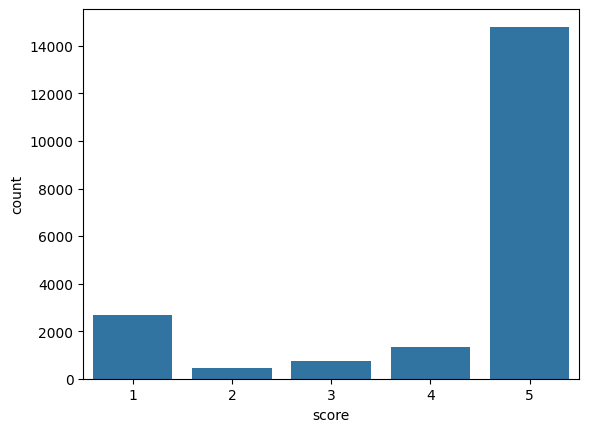

In [ ]:
sns.countplot(x='score', data=df)

From the chart above, the majority of users gave a rating of 5 which means this application has a good reputation.

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+|#[A-Za-z0-9]+|http\S+|\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    stp_wrds = set(stopwords.words('indonesian')) | set(stopwords.words('english'))
    filtered_words = [word for word in text if word not in stp_wrds]
    return filtered_words

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words

# slangwords
response = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/refs/heads/master/combined_slang_words.txt')
if response.status_code == 200:
    text = response.text.strip()
    slangwords = ast.literal_eval(text)
else:
    print('Failed')

def fix_slangwords(text):
    fixed_words = []

    for word in text:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    return fixed_words

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
df['cleaned'] = df['content'].astype(str).apply(cleaningText)
df['casefolding'] = df['cleaned'].apply(casefoldingText)
df['tokenizing'] = df['casefolding'].apply(tokenizingText)
df['filtering'] = df['tokenizing'].apply(filteringText)
df['stemming'] = df['filtering'].apply(stemmingText)
df['slangfixed'] = df['stemming'].apply(fix_slangwords)
df['cleaned_text'] = df['slangfixed'].apply(toSentence)
df.sample(5)

,content,score,cleaned,casefolding,tokenizing,filtering,stemming,slangfixed,cleaned_text
20521,Mengganti Email Yg salah Tidak Bs.alasan dari ...,1,Mengganti Email Yg salah Tidak Bsalasan dari M...,mengganti email yg salah tidak bsalasan dari m...,"[mengganti, email, yg, salah, tidak, bsalasan,...","[mengganti, email, yg, salah, bsalasan, menu, ...","[ganti, email, yg, salah, bsalasan, menu, apli...","[ganti, email, yang, salah, bsalasan, menu, ap...",ganti email yang salah bsalasan menu aplikasi ...
168105,Bagus,5,Bagus,bagus,[bagus],[bagus],[bagus],[bagus],bagus
56771,"Berani transparan, akuntabel dan profesional m...",4,Berani transparan akuntabel dan profesional ma...,berani transparan akuntabel dan profesional ma...,"[berani, transparan, akuntabel, dan, profesion...","[berani, transparan, akuntabel, profesional, l...","[berani, transparan, akuntabel, profesional, l...","[berani, transparan, akuntabel, profesional, l...",berani transparan akuntabel profesional lageng...
21445,tiba² duit ke sedot buat lybried studio gmn in...,1,tiba² duit ke sedot buat lybried studio gmn in...,tiba² duit ke sedot buat lybried studio gmn in...,"[tiba², duit, ke, sedot, buat, lybried, studio...","[tiba², duit, sedot, lybried, studio, gmn, min]","[tiba, duit, sedot, lybried, studio, gmn, min]","[tiba, duit, sedot, lybried, studio, gmn, min]",tiba duit sedot lybried studio gmn min
165160,"very useful app, must install!",5,very useful app must install,very useful app must install,"[very, useful, app, must, install]","[useful, app, must, install]","[useful, app, must, install]","[useful, app, must, install]",useful app must install


## Labelling

Labelling process is done based on the user review, each word in the text of user review will be checked and given a score based on a dictionary of positive and negative words, then the total score will be used as a reference to determine whether the text belongs to the positive, negative, or neutral sentiment category.

In [ ]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print('Failed')

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print('Failed')

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):

    score = 0

    for word in text:
      if (word in lexicon_positive):
        score = score + lexicon_positive[word]

    for word in text:
      if (word in lexicon_negative):
        score = score + lexicon_negative[word]

    sentiment=''

    if (score > 0):
      sentiment = 'positive'
    elif (score < 0):
      sentiment = 'negative'
    else:
      sentiment = 'neutral'

    return score, sentiment

In [ ]:
results = df['slangfixed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['sentiment'] = results[1]
print(df['sentiment'].value_counts())

sentiment
positive    9645
negative    6506
neutral     3849
Name: count, dtype: int64


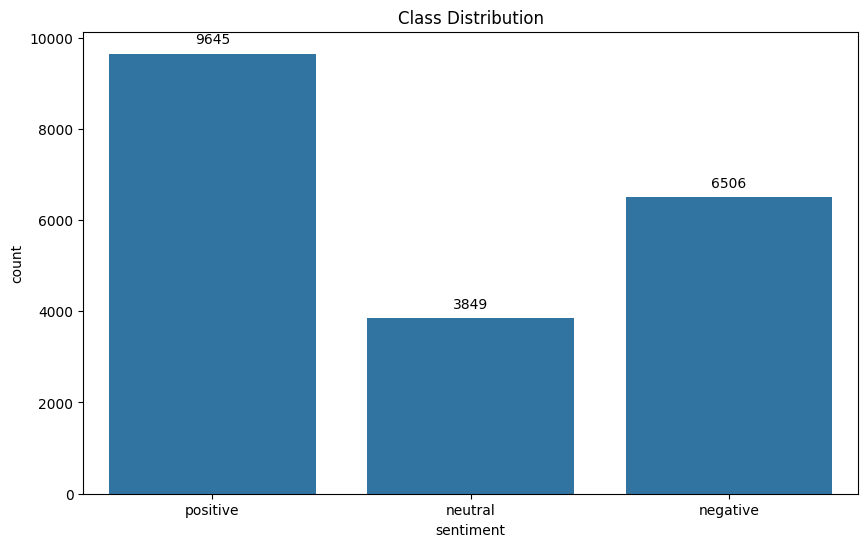

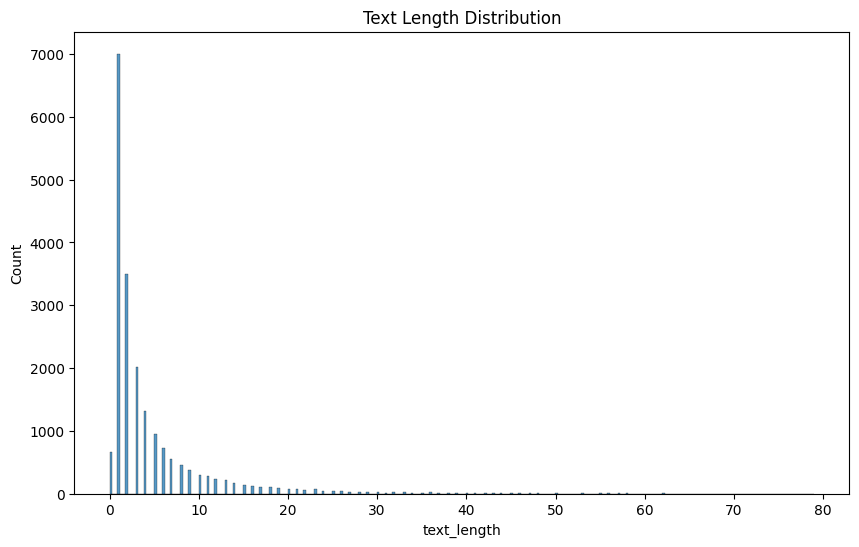

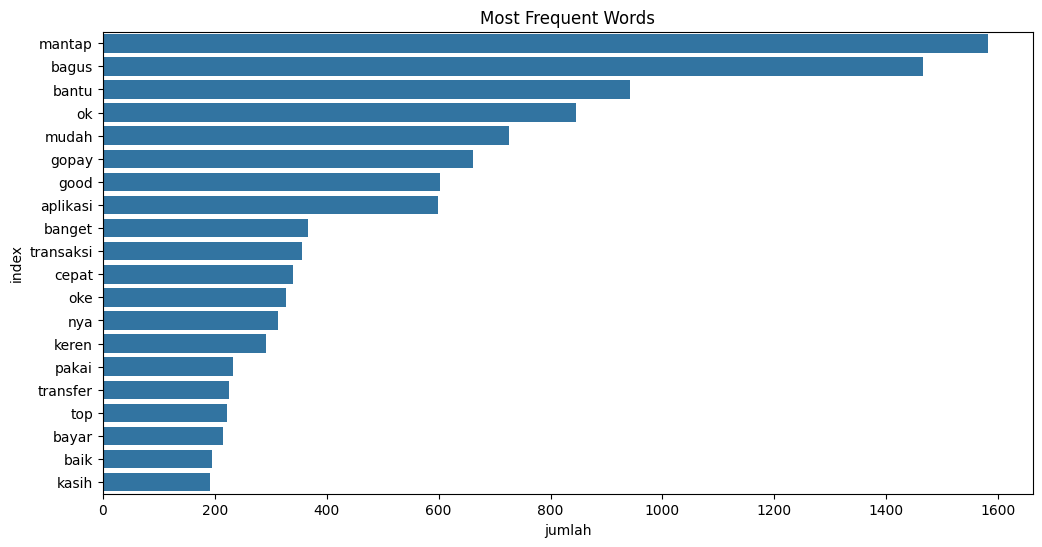

In [ ]:
# Class Distribution
plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Text length distribution
plt.figure(figsize=(10, 6))

df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Most frequent words
plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

As we can see, majority of the user reviews have positive sentiment followed by negative and neutral sentiment. The average text length ranges from 1-10 words. And the top three most frequently occuring words are 'mantap', 'bagus', and 'bantu'.

## Word Clouds

### Positive Sentiment

(-0.5, 599.5, 399.5, -0.5)

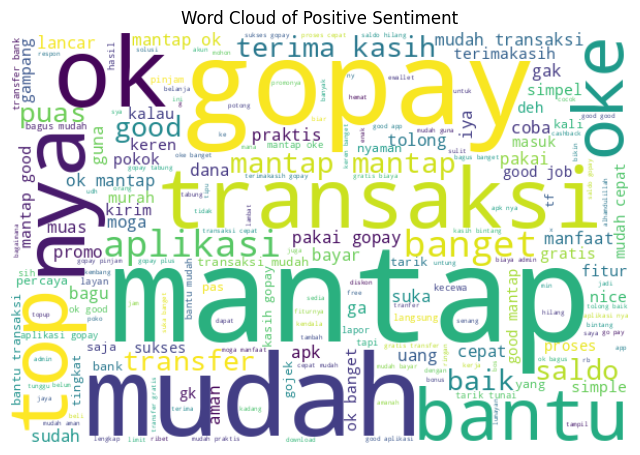

In [ ]:
df_p=df[df['sentiment']=='positive']
list_words = ''
for tweet in df_p['slangfixed']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(background_color='white', width=600, height=400, random_state=21, max_font_size=130).generate(list_words)
plt.figure(figsize=(8, 6))
plt.title('Word Cloud of Positive Sentiment')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

### Neutral Sentiment

(-0.5, 599.5, 399.5, -0.5)

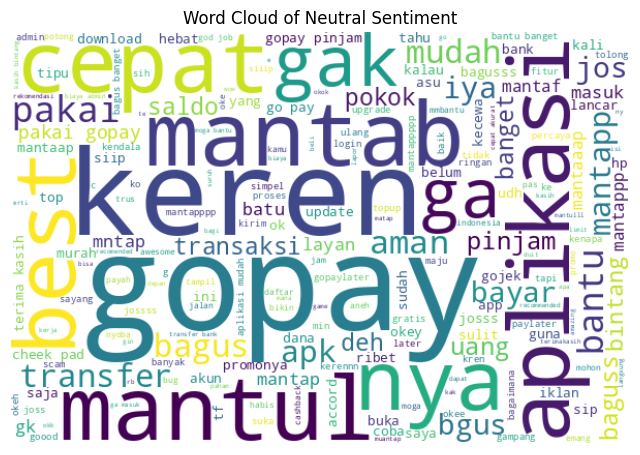

In [ ]:
df_net=df[df['sentiment']=='neutral']
list_words = ''
for tweet in df_net['slangfixed']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(background_color='white', width=600, height=400, random_state=21, max_font_size=130).generate(list_words)
plt.figure(figsize=(8, 6))
plt.title('Word Cloud of Neutral Sentiment')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

### Negative Sentiment

(-0.5, 599.5, 399.5, -0.5)

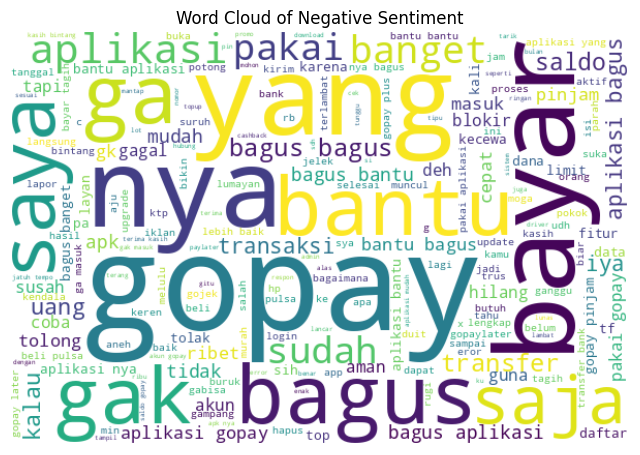

In [ ]:
df_n=df[df['sentiment']=='negative']
list_words = ''
for tweet in df_n['slangfixed']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(background_color='white', width=600, height=400, random_state=21, max_font_size=130).generate(list_words)
plt.figure(figsize=(8, 6))
plt.title('Word Cloud of Negative Sentiment')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

## Feature Extraction

Before the data is split, the feature data is extracted first with the TF-IDF method.

In [ ]:
X = df['cleaned_text']
y = df['sentiment']

In [ ]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,admin,aju,aktif,akun,aman,aneh,apa,apk,aplikasi,app,...,transfer,trus,tunai,tunggu,uang,udh,update,upgrade,verifikasi,yang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.715463,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153893,0.109280,0.0,...,0.140754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Spliting

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Modeling

In the modeling process, we will compare several algorithms to get the best performance model.

### Naive Bayes

In [ ]:
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train.toarray(), y_train)

y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.82525
Naive Bayes - accuracy_test: 0.833


### Random Forest

In [ ]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train.toarray(), y_train)

y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9654375
Random Forest - accuracy_test: 0.89525


### Logistic Regression

In [ ]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.910375
Logistic Regression - accuracy_test: 0.9095


### Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train.toarray(), y_train)

y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.9654375
Decision Tree - accuracy_test: 0.86325


## Evaluation

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [accuracy_train_nb, accuracy_train_rf, accuracy_train_lr, accuracy_train_dt],
    'Accuracy Test': [accuracy_test_nb, accuracy_test_rf, accuracy_test_lr, accuracy_test_dt]
})
accuracy_test_only = results_df[['Model', 'Accuracy Test']].sort_values(by='Accuracy Test', ascending=False)
print(accuracy_test_only)

                 Model  Accuracy Test
2  Logistic Regression        0.90950
1        Random Forest        0.89525
3        Decision Tree        0.86300
0          Naive Bayes        0.83300


In [ ]:
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


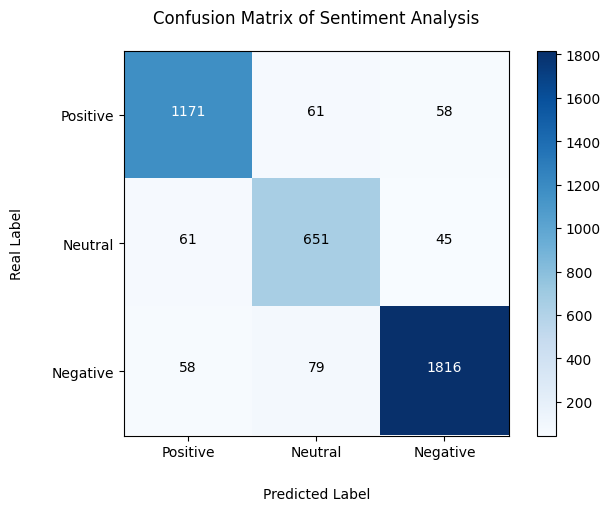

In [ ]:
plot_cm(confusion_matrix(y_test, y_pred_test_lr), classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

Based on the accuracy score of prediction results on the data_test, Logistic Regression model has the highest score of 0.9095 which means that the model successfully predicts 91% of the data_test correctly.

### Predict

Let's try to use the model to predict a new text.

In [ ]:
new_text = input('Input a new text: ')

# Preprocessing
new_text_cleaned = cleaningText(new_text)
new_text_casefolded = casefoldingText(new_text_cleaned)
new_text_tokenized = tokenizingText(new_text_casefolded)
new_text_filtered = filteringText(new_text_tokenized)
new_text_stemmed = stemmingText(new_text_filtered)
new_text_slangfixed = fix_slangwords(new_text_stemmed)
new_text_cleaned_text = toSentence(new_text_slangfixed)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_new_text = tfidf.transform([new_text_cleaned_text])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = logistic_regression.predict(X_new_text)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'positive':
    print('New text sentiment is POSITIVE.')
elif prediksi_sentimen[0] == 'neutral':
    print('New text sentiment is NEUTRAL.')
else:
    print('New text sentiment is NEGATIVE.')

Input a new text: Saldo tiba tiba terpotong sendiri, di aplikasi lain tidak ada riwayat pembayaran, hanya ada di gopay pdhl sy tdk pernah ada pembayaran tsb nominal hampil 200k, sudah saya laporkan juga tdk ada solusi
New text sentiment is NEGATIVE.
